In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

Используется устройство: cuda


In [ ]:
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask):
        super().__init__()
        self.register_buffer('mask', mask)  # Register mask as a buffer so it moves with the model

        # Scale and translation networks
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()  # Tanh to ensure stable training
        )

        self.translation_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, reverse=False):
        # Split input based on mask
        x_masked = x * self.mask

        # Get scale and translation factors
        s = self.scale_net(x_masked) * (1 - self.mask)
        t = self.translation_net(x_masked) * (1 - self.mask)

        if not reverse:
            # Forward transformation: x -> z
            z = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)
            # Log determinant of Jacobian
            log_det = torch.sum(s, dim=1)
            return z, log_det
        else:
            # Inverse transformation: z -> x
            x = x_masked + (1 - self.mask) * ((x - t) * torch.exp(-s))
            # Log determinant of Jacobian (negative of forward)
            log_det = -torch.sum(s, dim=1)
            return x, log_det

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.input_dim = input_dim
        self.layers = nn.ModuleList()

        # Create alternating masks for coupling layers
        for i in range(num_layers):
            # Alternating checkerboard pattern
            if i % 2 == 0:
                mask = torch.zeros(input_dim)
                mask[::2] = 1  # Set every other element to 1
            else:
                mask = torch.ones(input_dim)
                mask[::2] = 0  # Set every other element to 0

            self.layers.append(CouplingLayer(input_dim, hidden_dim, mask))

    def forward(self, x, reverse=False):
        log_det_sum = 0

        if not reverse:
            # Forward: data -> latent
            for layer in self.layers:
                x, log_det = layer(x, reverse=False)
                log_det_sum += log_det
        else:
            # Inverse: latent -> data
            for layer in reversed(self.layers):
                x, log_det = layer(x, reverse=True)
                log_det_sum += log_det

        return x, log_det_sum

    def sample(self, num_samples, device):
        # Sample from base distribution (standard normal)
        z = torch.randn(num_samples, self.input_dim).to(device)
        # Transform samples
        x, _ = self.forward(z, reverse=True)
        return x

In [ ]:
def preprocess_mnist(batch_size=128):
    # Load and flatten MNIST
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: 2 * x - 1),  # Scale to [-1, 1] for better training
        transforms.Lambda(lambda x: x.view(-1))  # Flatten 28x28 to 784
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [ ]:
def train_model(model, train_loader, num_epochs=50, lr=1e-4, device='cuda'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    train_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            # Forward pass through the model
            z, log_det = model(data)

            # Calculate NLL loss
            # -log(p(x)) = -log(p(z)) - log|det(dz/dx)|
            log_likelihood = 0.5 * torch.sum(z**2, dim=1) - log_det
            loss = torch.mean(log_likelihood)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f'Epoch: {epoch}, Average Loss: {avg_loss:.4f}')

    return train_losses

In [ ]:
def generate_samples(model, num_samples=25, device='cuda'):
    model.eval()
    with torch.no_grad():
        # Generate samples
        samples = model.sample(num_samples, device).cpu()

        # Reshape samples to 28x28 images and rescale from [-1,1] to [0,1]
        samples = (samples.view(-1, 28, 28).numpy() + 1) / 2

        # Plot samples
        fig, axes = plt.subplots(5, 5, figsize=(10, 10))
        for i, ax in enumerate(axes.flat):
            ax.imshow(samples[i], cmap='gray', vmin=0, vmax=1)
            ax.axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
input_dim = 28 * 28  # MNIST image size
hidden_dim = 1024
num_layers = 8
batch_size = 128
num_epochs = 30

In [ ]:
train_loader, test_loader = preprocess_mnist(batch_size)

In [ ]:
model = RealNVP(input_dim, hidden_dim, num_layers).to(device)

In [ ]:
train_losses = train_model(model, train_loader, num_epochs, device=device)

Epoch: 0, Batch: 0, Loss: 388.9498
Epoch: 0, Batch: 100, Loss: -1360.9670
Epoch: 0, Batch: 200, Loss: -1631.2142
Epoch: 0, Batch: 300, Loss: -1799.8907
Epoch: 0, Batch: 400, Loss: -1883.1252
Epoch: 0, Average Loss: -1522.0624
Epoch: 1, Batch: 0, Loss: -1950.5825
Epoch: 1, Batch: 100, Loss: -1971.3323
Epoch: 1, Batch: 200, Loss: -2007.9082
Epoch: 1, Batch: 300, Loss: -2025.5056
Epoch: 1, Batch: 400, Loss: -2000.5509
Epoch: 1, Average Loss: -1997.3123
Epoch: 2, Batch: 0, Loss: -2064.1338
Epoch: 2, Batch: 100, Loss: -2084.8662
Epoch: 2, Batch: 200, Loss: -2103.3494
Epoch: 2, Batch: 300, Loss: -2135.3662
Epoch: 2, Batch: 400, Loss: -2149.1958
Epoch: 2, Average Loss: -2103.8449
Epoch: 3, Batch: 0, Loss: -2156.6938
Epoch: 3, Batch: 100, Loss: -2174.6465
Epoch: 3, Batch: 200, Loss: -2151.6050
Epoch: 3, Batch: 300, Loss: -2199.2561
Epoch: 3, Batch: 400, Loss: -2182.4824
Epoch: 3, Average Loss: -2167.4382
Epoch: 4, Batch: 0, Loss: -2209.6196
Epoch: 4, Batch: 100, Loss: -2277.4028
Epoch: 4, Batc

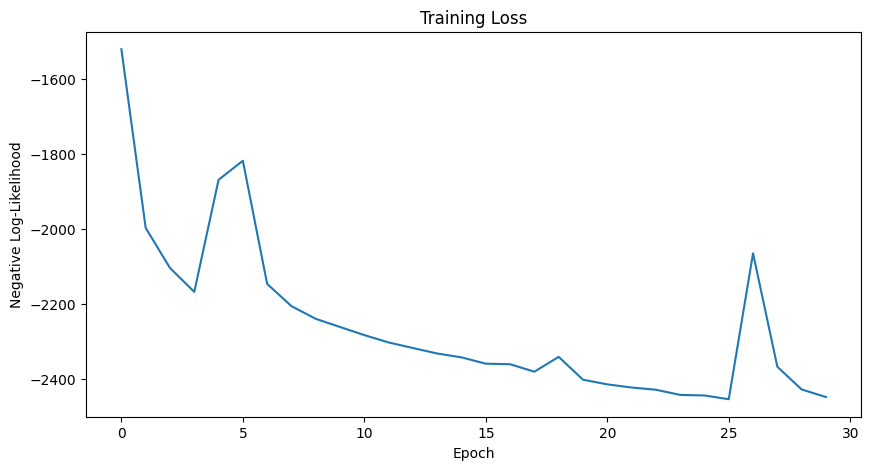

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.show()

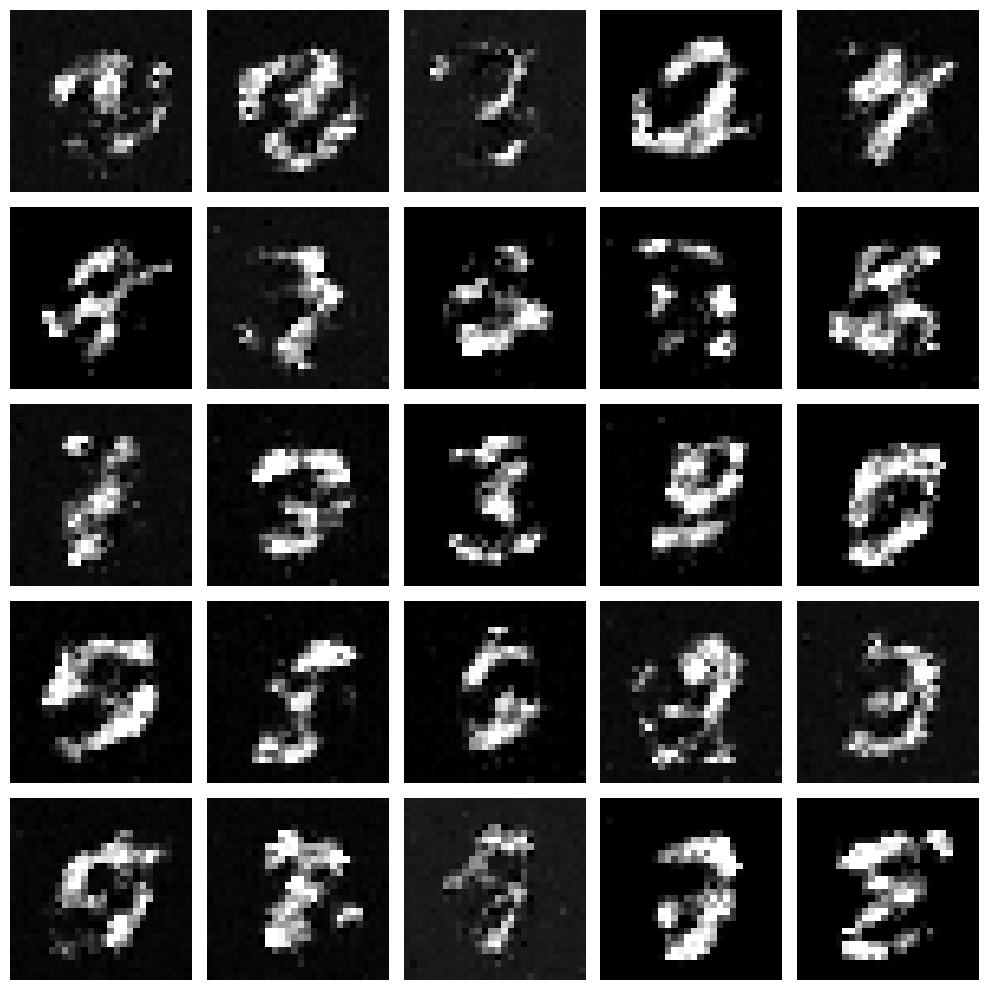

In [ ]:
generate_samples(model, num_samples=25, device=device)